<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#TODOs" data-toc-modified-id="TODOs-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>TODOs</a></span></li><li><span><a href="#Questions" data-toc-modified-id="Questions-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Questions</a></span></li><li><span><a href="#Links" data-toc-modified-id="Links-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Links</a></span></li><li><span><a href="#Interpreting-the-data" data-toc-modified-id="Interpreting-the-data-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Interpreting the data</a></span><ul class="toc-item"><li><span><a href="#EBA-data-columns" data-toc-modified-id="EBA-data-columns-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>EBA data columns</a></span></li></ul></li><li><span><a href="#Load" data-toc-modified-id="Load-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Load</a></span></li><li><span><a href="#Loading-bulk-datasets" data-toc-modified-id="Loading-bulk-datasets-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Loading bulk datasets</a></span><ul class="toc-item"><li><span><a href="#Co2-dataset" data-toc-modified-id="Co2-dataset-6.1"><span class="toc-item-num">6.1&nbsp;&nbsp;</span>Co2 dataset</a></span></li><li><span><a href="#Elec-dataset" data-toc-modified-id="Elec-dataset-6.2"><span class="toc-item-num">6.2&nbsp;&nbsp;</span>Elec dataset</a></span></li><li><span><a href="#Playing-with-the-data" data-toc-modified-id="Playing-with-the-data-6.3"><span class="toc-item-num">6.3&nbsp;&nbsp;</span>Playing with the data</a></span><ul class="toc-item"><li><span><a href="#Residuals-of-this-equation-per-BA" data-toc-modified-id="Residuals-of-this-equation-per-BA-6.3.1"><span class="toc-item-num">6.3.1&nbsp;&nbsp;</span>Residuals of this equation per BA</a></span></li><li><span><a href="#Visualize-some-BAs" data-toc-modified-id="Visualize-some-BAs-6.3.2"><span class="toc-item-num">6.3.2&nbsp;&nbsp;</span>Visualize some BAs</a></span></li></ul></li></ul></li><li><span><a href="#Visualizing-MEFs" data-toc-modified-id="Visualizing-MEFs-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Visualizing MEFs</a></span></li><li><span><a href="#Demand-MEF" data-toc-modified-id="Demand-MEF-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>Demand MEF</a></span></li></ul></div>

# TODOs

- How do you compute MEFs for the general + for each fuel type? (see the literature)
- How do those MEFs vary over time? Can you have an estimate for each hour of the day, for instance? 
- How do you compute the cost functions? 
- How do you retrieve the **relative** carbon intensity? Instead of the total carbon consumption? (I guess carbon_total/demand)?

Why is the MEF generation the same as the MEF demand? does that make sense? 

# Questions

@Anthony: those are notes to self. 

- Are we looking for long range interactions? 
- Automated discovery of production mix at the node level (based on energy trade)? 
- What fraction of the clealiness is attributable to your own production vs imports. What is the biggest contributor to the metric that you care about? How do you steer imports to optimize your own carbon benefit? 
- How to scale local energy mix to benefit globally? 
- What is the correlation with weather data? 

- Do we want total carbon consumption or only carbon intensity? 

# Links

web.stanford.edu/~jdechale/emissions_app/

# Interpreting the data

@Anthony: 
You will see that the columns of both datasets have specific names. 

They are usually a combination of 
- Balacing Authorities ID (e.g. CISO) 
- A tag explaining what we are looking at. See below for a detail of those tags. 
- For electricity, the type of generation. 


EBA data columns
----------------
- D: Demand
- NG: Net Generation
- TI: Total Interchange - (positive if exports)
- ID: Interchange with directly connected balancing authorities - (positive
    if exports)

# Load

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import os

from plotting_utils import plot_mef

In [3]:
from sklearn.linear_model import LinearRegression

In [4]:
DATA_PATH = os.getenv('CARBON_NETWORKS_DATA')

# Loading bulk datasets

In [5]:
fnm_co2 = os.path.join(DATA_PATH, 'EBA_co2.csv')
fnm_elec = os.path.join(DATA_PATH, 'EBA_elec.csv')

In [6]:
df_co2 = pd.read_csv(fnm_co2, index_col=0, parse_dates=True)

df_elec = pd.read_csv(fnm_elec, index_col=0, parse_dates=True)

## Co2 dataset

In [7]:
df_co2.head()

,CO2_AEC-MISO_ID,CO2_AEC-SOCO_ID,CO2_AECI-MISO_ID,CO2_AECI-SPA_ID,CO2_AECI-SWPP_ID,CO2_AECI-TVA_ID,CO2_AECI_D,CO2_AECI_NG,CO2_AECI_TI,CO2_AEC_D,...,CO2_WAUW_TI,CO2_WWA-NWMT_ID,CO2_WWA_D,CO2_WWA_NG,CO2_WWA_TI,CO2_YAD-CPLE_ID,CO2_YAD-DUK_ID,CO2_YAD_D,CO2_YAD_NG,CO2_YAD_TI
2018-07-01 00:00:00+00:00,53910.238614,126306.850701,48503.471201,-37853.314031,-68931.442144,149948.065955,2.502421e+06,2.594088e+06,91666.780981,557943.249171,...,-30200.475593,723.813327,11.999932,735.813259,723.813327,151.158440,574.929449,9.949614,736.037503,726.087889
2018-07-01 01:00:00+00:00,55659.969400,126785.749731,179851.395724,-44656.587903,-120554.448912,134517.096720,2.417334e+06,2.566492e+06,149157.455629,543170.037659,...,-33694.861584,769.276024,32.297701,801.573724,769.276024,169.238679,555.354051,10.685742,735.278472,724.592730
2018-07-01 02:00:00+00:00,54917.238769,100362.721240,272562.624457,-38508.124120,-176875.202815,143666.755049,2.287646e+06,2.488492e+06,200846.052572,512778.301291,...,-31667.756758,640.314543,16.979630,657.294173,640.314543,153.838800,562.382885,10.409602,726.631287,716.221686
2018-07-01 03:00:00+00:00,48236.292386,88842.372601,183041.374856,-43802.290159,-151062.189597,101097.945637,2.234720e+06,2.323995e+06,89274.840738,475956.787687,...,-27227.491983,882.444633,34.336250,916.780883,882.444633,-5263.112059,4152.423822,1123.102159,12.413922,-1110.688236
2018-07-01 04:00:00+00:00,43002.546305,83812.044113,-37755.463848,-54497.983419,-106821.689055,54144.294122,2.255946e+06,2.111015e+06,-144930.842200,408252.953360,...,-28780.313224,939.536537,71.649462,1011.186000,939.536537,-7998.470516,6877.259843,1125.210673,4.000000,-1121.210673


@Anthony: for instance, the first column above gives the CO2-emissions exchanged between AEC and MISO. 

In [8]:
#extracting the names of the BAs present in the dataset
nms = []
fields = []

for c in df_co2.columns:
    
    nms.append(c.split('_')[1])
    fields.append(c.split('_')[-1])

BAs = []
for nm in nms:
    if '-' in nm:
        pass
    else:
        BAs.append(nm)

In [9]:
BAs = np.unique(BAs)

In [10]:
print("These are the names of the Balancing Authorities present in the dataset")
print(BAs)
print(f"\nThere are {len(BAs)} BAs.")

These are the names of the Balancing Authorities present in the dataset
['AEC' 'AECI' 'AESO' 'AVA' 'AVRN' 'AZPS' 'BANC' 'BCHA' 'BPAT' 'CEN' 'CFE'
 'CHPD' 'CISO' 'CPLE' 'CPLW' 'DEAA' 'DOPD' 'DUK' 'EEI' 'EPE' 'ERCO' 'FMPP'
 'FPC' 'FPL' 'GCPD' 'GRID' 'GRIF' 'GRMA' 'GVL' 'GWA' 'HGMA' 'HQT' 'HST'
 'IESO' 'IID' 'IPCO' 'ISNE' 'JEA' 'LDWP' 'LGEE' 'MHEB' 'MISO' 'NBSO'
 'NEVP' 'NSB' 'NWMT' 'NYIS' 'OVEC' 'PACE' 'PACW' 'PGE' 'PJM' 'PNM' 'PSCO'
 'PSEI' 'SC' 'SCEG' 'SCL' 'SEC' 'SEPA' 'SOCO' 'SPA' 'SPC' 'SRP' 'SWPP'
 'TAL' 'TEC' 'TEPC' 'TIDC' 'TPWR' 'TVA' 'WACM' 'WALC' 'WAUW' 'WWA' 'YAD']

There are 76 BAs.


## Elec dataset

In [11]:
df_elec.head()

,EBA.AEC-ALL.D.H,EBA.AEC-ALL.NG.COL.H,EBA.AEC-ALL.NG.H,EBA.AEC-ALL.NG.NG.H,EBA.AEC-ALL.NG.OTH.H,EBA.AEC-ALL.NG.WAT.H,EBA.AEC-ALL.TI.H,EBA.AEC-MISO.ID.H,EBA.AEC-SOCO.ID.H,EBA.AECI-ALL.D.H,...,EBA.WWA-ALL.NG.H,EBA.WWA-ALL.NG.WND.H,EBA.WWA-ALL.TI.H,EBA.WWA-NWMT.ID.H,EBA.YAD-ALL.D.H,EBA.YAD-ALL.NG.H,EBA.YAD-ALL.NG.WAT.H,EBA.YAD-ALL.TI.H,EBA.YAD-CPLE.ID.H,EBA.YAD-DUK.ID.H
2018-07-01 00:00:00+00:00,852.088828,395.589543,1127.315688,726.630120,4.048013,1.048013,275.226860,82.331513,192.895347,3736.834955,...,61.317772,61.317772,60.317777,60.317777,2.487404,184.009376,184.009376,181.521972,37.789610,143.732362
2018-07-01 01:00:00+00:00,821.171036,399.680353,1096.994682,691.092041,4.111144,2.111144,275.823646,84.147415,191.676231,3509.233553,...,66.797810,66.797810,64.106335,64.106335,2.671435,183.819618,183.819618,181.148183,42.309670,138.838513
2018-07-01 02:00:00+00:00,762.904264,381.317775,993.927580,607.992727,3.617078,1.000000,231.023316,81.705087,149.318229,3265.266416,...,54.774514,54.774514,53.359545,53.359545,2.602400,181.657822,181.657822,179.055421,38.459700,140.595721
2018-07-01 03:00:00+00:00,707.077333,351.154277,910.720225,555.557480,3.008468,1.000000,203.642892,71.659423,131.983469,3231.656110,...,76.398407,76.398407,73.537053,73.537053,3.170032,3.103481,3.103481,-0.066552,-11.787050,11.720499
2018-07-01 04:00:00+00:00,641.677343,266.336549,840.999966,569.729487,3.466965,1.466965,199.322623,67.589859,131.732764,3175.450535,...,84.265500,84.265500,78.294711,78.294711,3.293148,1.000000,1.000000,-2.293148,-22.420788,20.127640


@Anthony: the format of this electricity dataset is a bit different. The format of the column name is 
- **EBA.ba_name-ALL.[D,NG,TI].H** for the [demand, net_generation, total_interchange] hourly for BA ba_name
- **EBA.ba_name-other_ba_name.ID.H** for the interchange between ba_name and other_ba_name

Also, you will have a column like **EBA.ba_name-ALL.NG.SOURCE.H** where **SOURCE** is going to be water, wind, coal, ...

For instance, for **MISO**, we see that it exchanges with a bunch of BAs. We also know that it produces nuclear, oil, sun, hydro, wind, and "others"

In [12]:
for c in df_elec.columns:
    if 'MISO-' in c:
        print(c)

EBA.MISO-AEC.ID.H
EBA.MISO-AECI.ID.H
EBA.MISO-ALL.D.H
EBA.MISO-ALL.NG.COL.H
EBA.MISO-ALL.NG.H
EBA.MISO-ALL.NG.NG.H
EBA.MISO-ALL.NG.NUC.H
EBA.MISO-ALL.NG.OIL.H
EBA.MISO-ALL.NG.OTH.H
EBA.MISO-ALL.NG.SUN.H
EBA.MISO-ALL.NG.WAT.H
EBA.MISO-ALL.NG.WND.H
EBA.MISO-ALL.TI.H
EBA.MISO-EEI.ID.H
EBA.MISO-IESO.ID.H
EBA.MISO-LGEE.ID.H
EBA.MISO-MHEB.ID.H
EBA.MISO-PJM.ID.H
EBA.MISO-SOCO.ID.H
EBA.MISO-SPA.ID.H
EBA.MISO-SWPP.ID.H
EBA.MISO-TVA.ID.H


We can check that the columns **NG.H** is the sum of columns **NG.SOURCE.H**. 


## Playing with the data

Here we check that the conservation equation is verified in the data. 

In [13]:
eba = 'AECI'

In [14]:
D_col = f'EBA.{eba}-ALL.D.H'
TI_col = f'EBA.{eba}-ALL.TI.H'
NG_col = f'EBA.{eba}-ALL.NG.H'

In [15]:
df_elec[NG_col].head()

2018-07-01 00:00:00+00:00    3431.676061
2018-07-01 01:00:00+00:00    3331.347054
2018-07-01 02:00:00+00:00    3173.345935
2018-07-01 03:00:00+00:00    2972.599338
2018-07-01 04:00:00+00:00    2639.206404
Name: EBA.AECI-ALL.NG.H, dtype: float64

In [16]:
(df_elec[D_col] + df_elec[TI_col]).head()

2018-07-01 00:00:00+00:00    3431.676061
2018-07-01 01:00:00+00:00    3331.347054
2018-07-01 02:00:00+00:00    3173.345935
2018-07-01 03:00:00+00:00    2972.599338
2018-07-01 04:00:00+00:00    2639.206404
dtype: float64

The equation at each node is simply:
$$
D + TI = NG
$$


### Residuals of this equation per BA

In [17]:
stats_res = dict()

for ba in BAs:

    D_col = f'EBA.{ba}-ALL.D.H'
    TI_col = f'EBA.{ba}-ALL.TI.H'
    NG_col = f'EBA.{ba}-ALL.NG.H'
    res = df_elec[D_col] + df_elec[TI_col] - df_elec[NG_col]
    mean_res = np.mean(res)
    std_res = np.std(res)
    
    stats_res[ba] = (mean_res, std_res)

We see that the above equation satisfied for all BAs in the dataset. 

For each BA, we see the (mean residual, std of residuals)

In [18]:
stats_res

{'AEC': (1.8372287534498327e-10, 4.335108493734617e-09),
 'AECI': (7.620679234423212e-10, 1.1242985498596981e-08),
 'AESO': (2.369696483197441e-07, 2.5573384358987293e-06),
 'AVA': (1.291604423450939e-10, 3.221511409193837e-08),
 'AVRN': (1.5425676720125344e-08, 5.18433539827764e-07),
 'AZPS': (-6.139611740370434e-10, 7.565341838771681e-08),
 'BANC': (-8.242345062712367e-11, 3.608550759943506e-08),
 'BCHA': (5.204303290323906e-09, 3.6062215478534337e-07),
 'BPAT': (2.2167170581497814e-10, 1.0582379948695873e-07),
 'CEN': (9.214239763098751e-08, 2.3254153673158083e-06),
 'CFE': (1.7488518849849467e-06, 3.6878006148851587e-06),
 'CHPD': (-1.6319335167790966e-11, 3.545373835498706e-08),
 'CISO': (-4.212671495671756e-10, 9.034732384375288e-08),
 'CPLE': (9.187419137652892e-11, 2.229277054897387e-08),
 'CPLW': (4.540790184029166e-10, 6.82688136153282e-09),
 'DEAA': (2.7885019569706315e-10, 2.5061740166597196e-08),
 'DOPD': (-6.313073725947145e-11, 2.384432891419929e-08),
 'DUK': (-2.1284692

### Visualize some BAs

In [19]:
ba = 'CISO'

In [20]:
D_col = f'EBA.{ba}-ALL.D.H'
TI_col = f'EBA.{ba}-ALL.TI.H'
NG_col = f'EBA.{ba}-ALL.NG.H'

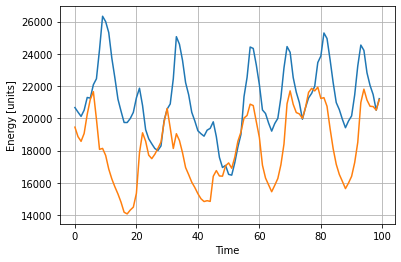

In [21]:
plt.plot(df_elec[D_col].values[-100:], label = 'Demand')
plt.plot(df_elec[NG_col].values[-100:], label = 'NetGeneration')
plt.xlabel("Time")
plt.ylabel("Energy [units]")
plt.grid()


# Visualizing MEFs

I think the equation for MEF is usually: 
$$
 \Delta E\propto \Delta G (MEF)
$$
(I would have to check), where $\Delta G$ is the change in generation and $\Delta E$ is the change in emissions. 

Let us try to visualize the MEF for one BA in particular

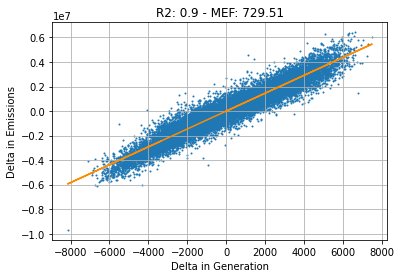

In [22]:
ba = 'MISO'

_ = plot_mef(ba, df_elec, df_co2, which='generation')

The slope of the linear regression to the above point cloud is the MEF. 

However, for some BAs with a lot of renewable generation (e.g. CISO), the MEF is not as well defined. We would have to see how this very value of the MEF changes depending on the time of the day for instance. (as the share of renewables is much different from hour to hour I am guessing). 

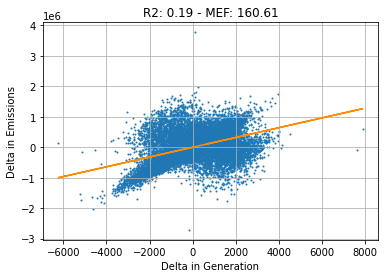

In [23]:
ba = 'CISO'

_ = plot_mef(ba, df_elec, df_co2, which='generation')

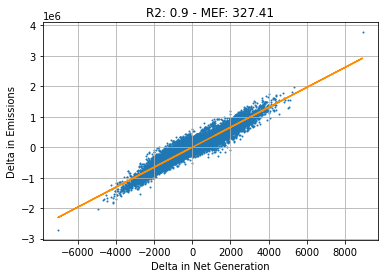

In [24]:
ba = 'CISO'

_ = plot_mef(ba, df_elec, df_co2, which='net_generation')

In [25]:
NG_col = f'EBA.{ba}-ALL.NG.H'

In [26]:
WND_col = f'EBA.{ba}-ALL.NG.WND.H'

SUN_col = f'EBA.{ba}-ALL.NG.SUN.H'

In [27]:
df_elec[NG_col] - df_elec[[WND_col, SUN_col]].sum(axis=1)

2018-07-01 00:00:00+00:00    16433.510684
2018-07-01 01:00:00+00:00    17609.539449
2018-07-01 02:00:00+00:00    19647.386283
2018-07-01 03:00:00+00:00    19942.150046
2018-07-01 04:00:00+00:00    19228.279051
                                 ...     
2021-04-13 17:00:00+00:00     8483.942356
2021-04-13 18:00:00+00:00     7811.635385
2021-04-13 19:00:00+00:00     7755.559801
2021-04-13 20:00:00+00:00     7406.906762
2021-04-13 21:00:00+00:00     7197.362566
Length: 24430, dtype: float64

In [28]:
df_elec.columns

Index(['EBA.AEC-ALL.D.H', 'EBA.AEC-ALL.NG.COL.H', 'EBA.AEC-ALL.NG.H',
       'EBA.AEC-ALL.NG.NG.H', 'EBA.AEC-ALL.NG.OTH.H', 'EBA.AEC-ALL.NG.WAT.H',
       'EBA.AEC-ALL.TI.H', 'EBA.AEC-MISO.ID.H', 'EBA.AEC-SOCO.ID.H',
       'EBA.AECI-ALL.D.H',
       ...
       'EBA.WWA-ALL.NG.H', 'EBA.WWA-ALL.NG.WND.H', 'EBA.WWA-ALL.TI.H',
       'EBA.WWA-NWMT.ID.H', 'EBA.YAD-ALL.D.H', 'EBA.YAD-ALL.NG.H',
       'EBA.YAD-ALL.NG.WAT.H', 'EBA.YAD-ALL.TI.H', 'EBA.YAD-CPLE.ID.H',
       'EBA.YAD-DUK.ID.H'],
      dtype='object', length=866)

# Demand MEF

Here we do the same as above for demand

We define the demand_MEF as 
$$
 \Delta E\propto \Delta D 
$$

Let us try to visualize the MEF for one BA in particular

In [29]:
ba = 'MISO'

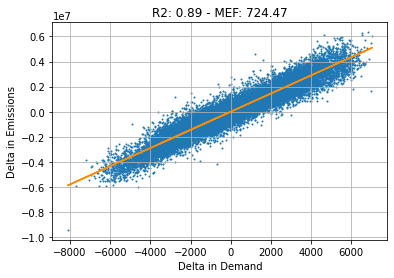

In [30]:
ba_, ba_co2 = plot_mef(ba, df_elec, df_co2, which='demand')

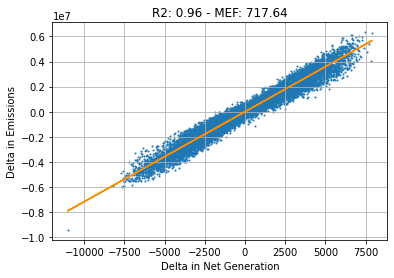

In [31]:
ba_, ba_co2 = plot_mef(ba, df_elec, df_co2, which='net_demand')

In [32]:
ba = 'CISO'

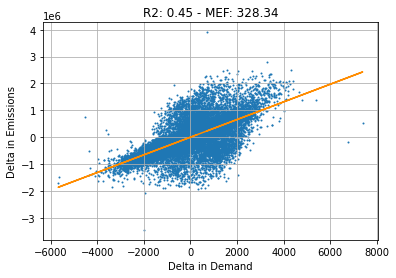

In [33]:
ba_, ba_co2 = plot_mef(ba, df_elec, df_co2, which='demand')

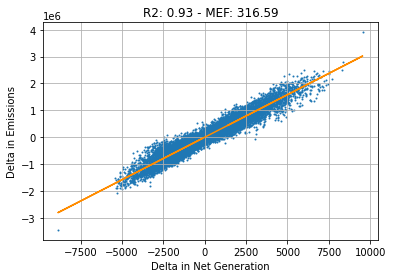

In [34]:
ba_, ba_co2 = plot_mef(ba, df_elec, df_co2, which='net_demand')